# Table of Contents
<p><div class="lev2 toc-item"><a href="#Smooth-Pycnophylactic-Interpolation-using-GeoPandas-and-Rasterio" data-toc-modified-id="Smooth-Pycnophylactic-Interpolation-using-GeoPandas-and-Rasterio"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Smooth Pycnophylactic Interpolation using GeoPandas and Rasterio</a></div><div class="lev1 toc-item"><a href="#Usage" data-toc-modified-id="Usage-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Usage</a></div><div class="lev1 toc-item"><a href="#Reference" data-toc-modified-id="Reference-3"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reference</a></div><div class="lev1 toc-item"><a href="#Acknowledgement" data-toc-modified-id="Acknowledgement-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Acknowledgement</a></div><div class="lev1 toc-item"><a href="#Example" data-toc-modified-id="Example-3"><span class="toc-item-num">4&nbsp;&nbsp;</span>Example</a></div>

# Smooth Pycnophylactic Interpolation using GeoPandas and Rasterio

## Usage

The basic function pycno() accepts a GeoPandas GeoDataFrame, the column name of the field that you wish to smooth and the desired cell size of the output raster.

The algorithm then iterative smooths the chosen data values, adjusting for non-negativity and preserving volume. The parameter r allows the adjustment of the realxation parameter, but in practice the default is fine. The converge parameter sets the stopping point, which is calculated as the initial maximum value * 10 raise to the negative of the converge parameter. Generally, 3 is a good default, but it may need adjustment for some applications, generally the larger the converge parameter, the more iterations are required and the longer the function takes to complete and return an output.

The handle_nulls parameter is based on Tobler's discussion of boundary conditions. The basic implementation (handle_nulls = False) uses the standard numpy convolve function and sets nodata values to 0. Tobler calls this the Dirichlet condition, acknowledging that values other than 0 are possible dependent upon context, although not implemented here. The other option, Tobler calls the Neumann condition, in which the density gradient at edges is set to zero. This is not implemented here, instead the astropy convolve function is used in preference, which has much the same effect. The astropy convolve function replaces null values using the kernel as an interpolation function (handle_nulls = True), this is the default option.

The function outputs a 2D numpy array, geotransformation information, and the coordinate reference system.

As the main output is a numpy array, the matplotlib.pyplot function imshow() can be used to get a quick look at the output.

The save_pycno() helper function takes the outputs from pycno() and saves the array as a Raster using Rasterio, which can then be used in a GIS etc.

The extract_values() function allows for the estimation of value sums from the smooth pycnophylactic interpolation surface to a set of polygons.

NB The field used for smoothing must be non-negative, it is also assumed that an equal-area projection is being used. The GeoDataFrame should be structured so that 1 row is 1 record. Multipolygons are fine, but if they are split into singleparts you will likely get an incorrect output.

## Reference

Tobler W. 1979. Smooth Pycnophylactic Interpolation for Geographical Regions. Journal of the American Statistical Association. 74: 367: 519-530.

## Acknowledgement

The code here is (for the most part) adapted from Chris Brunsdon's (https://github.com/chrisbrunsdon) R package 'pycno' - https://github.com/cran/pycno

## Example

In [2]:
# Some required libraries
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# import the pycnophylactic smoothing function
from pycno.pycno import pycno, save_pycno, extract_values

%matplotlib inline

In [2]:
# Get some data for London
# Read in London Boroughs geojson and project to British National Grid.
ldn_boro = gpd.read_file('data/LDN_Boro.geojson').to_crs(epsg=27700)

# Get some population data for London Boroughs
ldn_pop = pd.read_excel('data/Pandas_Lon_Pop.xlsx')

# Merge the population data with the geospatial data
ldn_boro = ldn_boro.merge(ldn_pop, how='left', left_on='GSS_CODE', right_on='New Code')

In [5]:
# Create the smooth pycnophylactic surface
res, trans, crs = pycno(ldn_boro,2015,50,converge=4,verbose=False)

# NB runtime warnings derive from np.nan not being handled by the < and abs operators. Nothing to worry about here.

# Save the output as a raster
save_pycno(res,trans,crs,'london_pycno.tif')

pycno\pycno.py:138: RuntimeWarning: invalid value encountered in less
  value_array[value_array<0] = 0.0
pycno\pycno.py:146: RuntimeWarning: invalid value encountered in absolute
  if nanmax(absolute(old - value_array)) < stopper:


(-0.5, 1166.5, 900.5, -0.5)

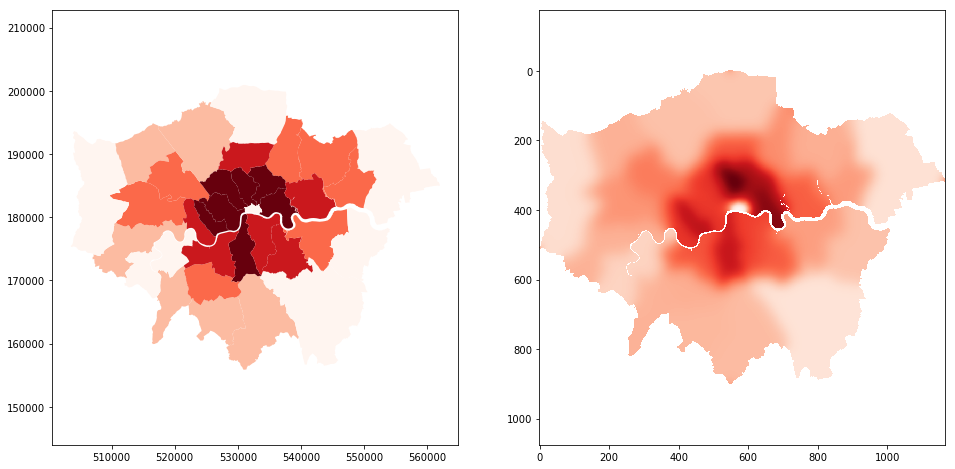

In [7]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,8))

# ax1
ldn_boro['popdense2015'] = ldn_boro[2015]/(ldn_boro['geometry'].area * 1000000)
ldn_boro.plot(column = 'popdense2015',cmap = 'Reds', scheme = 'Quantiles', k=5,ax=ax1)
ax1.axis('equal')

# ax2
ax2.imshow(res, cmap = 'Reds')
ax2.axis('equal')

In [12]:
# Check that volumes have been preserved by extracting the estimates back to the original
ldn_pop_est = extract_values(res,ldn_boro,trans)
ldn_pop_est.head()

,GSS_CODE,HECTARES,NAME,NONLD_AREA,ONS_INNER,SUB_2006,SUB_2009,geometry,New Code,Area name,...,2008,2009,2010,2011,2012,2013,2014,2015,popdense2015,Estimate
0,E09000021,3726.117,Kingston upon Thames,0.000,F,,,"POLYGON ((516401.6008347637 160201.7994140856,...",E09000021,Kingston upon Thames,...,156000.0,157300,158600,160400,163900,166800,170000,173525,4.656992e-09,173525.0
1,E09000008,8649.441,Croydon,0.000,F,,,"POLYGON ((535009.2008389848 159504.6994170326,...",E09000008,Croydon,...,349300.0,352800,358000,364800,368900,372800,376000,379031,4.382143e-09,379031.0
2,E09000006,15013.487,Bromley,0.000,F,,,"POLYGON ((540373.6008397819 157530.3994170626,...",E09000006,Bromley,...,305000.0,306900,308600,310600,314000,317900,321300,324857,2.163768e-09,324857.0
3,E09000018,5658.541,Hounslow,60.755,F,,,"POLYGON ((521975.8008395391 178099.9994231847,...",E09000018,Hounslow,...,237900.0,243400,249200,254900,259100,262400,265600,268770,4.805795e-09,268770.0
4,E09000009,5554.428,Ealing,0.000,F,,,"POLYGON ((510253.5008375183 182881.5994233852,...",E09000009,Ealing,...,324000.0,330000,334100,339300,340700,342500,342100,343059,6.176308e-09,343059.0
